In [113]:
import numpy as np
import astropy.cosmology as apcos
from astropy import units as u
from astropy import constants as const


cosmo = apcos.WMAP7 

h = u.def_unit('h', cosmo.H0 / (100 * (u.km / u.s) / u.Mpc))


In [116]:
def interpolate_cen_cen(xi, yi, zi, vxi, vyi, vzi, xf, yf, zf, vxf, vyf, vzf, z_red_i, z_red_f, z_red_interpolate):
    '''
    xi, yi, zi are resecptively all arrays of the initial x,y,z coordinates of each galaxy.
    xf, yf, zf are resecptively all arrays of the final x,y,z coordinates of each galaxy.
    vxi, vyi, vzi are resecptively all arrays of the initial velocity in the x,y,z directions, for each galaxy.
    vxf, vyf, vzf are resecptively all arrays of the final velocity in the x,y,z directions, for each galaxy.
    z_red_i, z_red_f are respectively the initial and final redshifts of the galaxies.
    z_red_interpolate is an array of the redshifts for interpolation, and should be between z_red_i and z_red_f.
    
    All galaxys should have the same initial and final times, and will be interpolated at the same locations.
    
    Note:  Units need to be Mpc/h for distances, and km/s for vecloties'''
    
    time_interp = cosmo.age(z_red_interpolate)
    ti, tf = cosmo.age([z_red_i, z_red_f])
        
    tscaled = (time_interp - ti) / (tf - ti)
    
    unit_scale = (u.km / u.s * (tf-ti)).to(u.Mpc / h).value  #it's a unit thing
    
    xinit = np.asarray([xi, yi, zi]).T #* u.Mpc / h
    xfin  = np.asarray([xf, yf, zf]).T #* u.Mpc / h
    vinit = np.asarray([vxi, vyi, vzi]).T * unit_scale
    vfin  = np.asarray([vxf, vyf, vzf]).T * unit_scale
    
    # Rescale t so that t1 = 0 and t2 = 1, then
    # A = x(t1)
    # B = v(t1)
    # C = -2*v(t1) - 3*x(t1) - v(t2) + 3*x(t2)
    # D = v(t1) + v(t2) + 2*(x(t1)-x(t2))
    
    # x(t) = A + B*t + C*t**2 + D*t**3
    # v(t) = B + 2*C*t + 3*D*t**2  
    
     
    A = xinit
    B = vinit
    C = -2*vinit - 3*xinit - vfin + 3*xfin
    D = vinit + vfin + 2*(xinit-xfin)
        
    
    pos_interp = np.add(A, np.tensordot(tscaled,B,axes=0) + 
                  np.tensordot(np.power(tscaled,2),C,axes=0) + np.tensordot(np.power(tscaled,3),D,axes=0))
    
    vel_interp = np.add(B, 2*np.tensordot(tscaled,C,axes=0) + 
                  3*np.tensordot(np.power(tscaled,2),D,axes=0))
    
    return time_interp.value, pos_interp, vel_interp
       

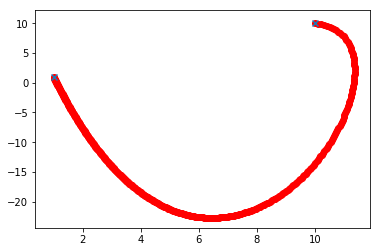

In [115]:
#Note: My personal testing

import matplotlib.pyplot as pyplot

init, fin = [1,1,0], [10,10,0]
initv, finv = [5000, -50000, 0], [-4000, 2000, 0]

times, pos, vel = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],5,1,np.arange(1,5,0.01))

#print pos

#print vel

pyplot.figure()
pyplot.scatter(pos[:,0], pos[:,1], c="red")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], marker="x")
pyplot.show()





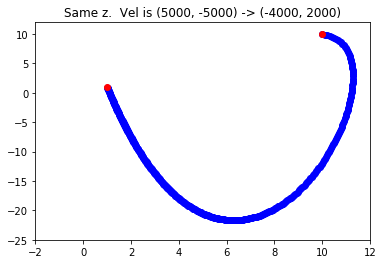

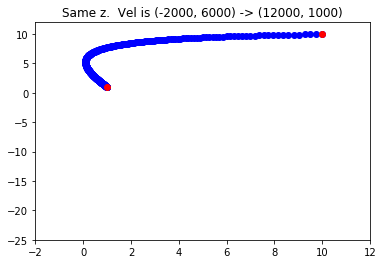

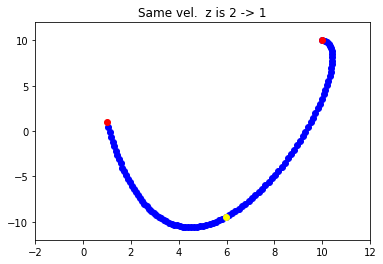

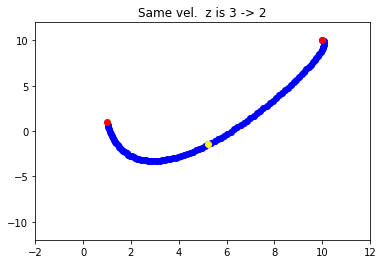

In [104]:
import matplotlib.pyplot as pyplot

init, fin = [1,1,0], [10,10,0]
initv, finv = [5000, -50000, 0], [-4000, 2000, 0]

times, pos, vel = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],5,1,np.arange(1,5,0.01))

#print pos

#print vel

pyplot.figure()
pyplot.title("Same z.  Vel is (5000, -5000) -> (-4000, 2000)")
pyplot.scatter(pos[:,0], pos[:,1], c="blue")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c="red")
pyplot.xlim([-2, 12])
pyplot.ylim([-25,12])
pyplot.show()


import matplotlib.pyplot as pyplot

init, fin = [1,1,0], [10,10,0]
initv, finv = [-2000, 6000, 0], [9000, 600,0]

times, pos, vel = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],5,1,np.arange(1,5,0.01))

#print pos

#print vel

pyplot.figure()
pyplot.title("Same z.  Vel is (-2000, 6000) -> (12000, 1000)")
pyplot.scatter(pos[:,0], pos[:,1], c="blue")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c="red")
pyplot.xlim([-2, 12])
pyplot.ylim([-25,12])
pyplot.show()






init, fin = [1,1,0], [10,10,0]
initv, finv = [5000, -50000, 0], [-4000, 2000, 0]

times, pos, vel = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],2,1,np.arange(1,2,0.01))

st, sp, sv = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],2,1,1.5)

#print pos

#print vel

pyplot.figure()
pyplot.title("Same vel.  z is 2 -> 1")
pyplot.scatter(pos[:,0], pos[:,1], c="blue")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c="red")
pyplot.scatter(sp[0], sp[1], c="yellow")
pyplot.xlim([-2, 12])
pyplot.ylim([-12,12])
pyplot.show()






init, fin = [1,1,0], [10,10,0]
initv, finv = [5000, -50000, 0], [-4000, 2000, 0]

times, pos, vel = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],3,2,np.arange(2,3,0.01))
                    
st, sp, sv = interpolate_cen_cen(init[0],init[1],init[2],initv[0],initv[1],initv[2],
                    fin[0],fin[1],fin[2],finv[0],finv[1],finv[2],3,2,2.5)

#print pos

#print vel

pyplot.figure()
pyplot.title("Same vel.  z is 3 -> 2")
pyplot.scatter(pos[:,0], pos[:,1], c="blue")
pyplot.scatter([init[0], fin[0]], [init[1], fin[1]], c="red")
pyplot.scatter(sp[0], sp[1], c="yellow")
pyplot.xlim([-2, 12])
pyplot.ylim([-12,12])
pyplot.show()
